# Fakebusters: Data description and Pipeline

## Motivation

The goal of our project is to perform person identification in videos, in a way that is robust to deepfake forgeries, in particular those that rely on face swapping techniques (See:) . Existing speaker identification techniques of video rely heavily either on facial recognition of static image data or audio signal processing . Recent research has demostrated the efficacy of deep learning approaches to create high quality forgeries of both facial features (https://www.youtube.com/watch?v=O7JOD-qytb8) and voices (http://talkobamato.me), suggesting the need for an approach that does not rely exclusively on this data to perform person identificaction. This notebook suggest and alternative approach, presenting a dataset and a data pipeline design that can be used to explore new models for this task. 

## Hypothesis

We believe that the 'biometric' signal of facial expressions can be used in the task of speaker identification. Given that face swapping techniques can forge facial features and speech but the facial expressions are not the ones of the real person but of the 'actor' that is wearing their 'mask', a classifier that relies on this signal will be resistant to these kind of fakes.

In an ideal scenario, we would like to test our hypothesis on a large dataset with thousands of different people in it[CITE VOXCELEB]. However, given the computation and time limitations we started with the videos of 12 world and national leaders. The details about the data collection and pre-processing are explained below. The took the following steps for our the data creation:
<ul>
  <li>data download</li>
  <li>selection of good video segments</li>
  <li>landmark extraction</li>
</ul>


In [1]:
%load_ext autoreload
%autoreload 2
%pylab inline
import numpy as np
import pandas as pd
import os

Populating the interactive namespace from numpy and matplotlib


## 1) Data Download

For each of the 12 leaders, we downloaded videos from YouTube where the person of interest (POI) is speaking either in a formal interview, a debate, a public speech, or a weekly address. The total count and hours of YouTube videos downloaded for each leader are given below. The txt files with the downloaded links are provided in links folder. 

The number and duration of videos downloaded is maximum for Barack Obama and mimimum for Michelle Obama. 

In [4]:
#--------------------------------DEFINE USER IDENTITIES-----------------------------------
identities=['bernie','biden','hillary','justin','may','michelle','modi','obama','pelosi','putin','trump','warren']
lastNames = np.array(['Sanders','Biden','Clinton','Trudeau','May','Michelle','Modi','Obama','Pelosi','Putin','Trump','Warren'])
sid = np.argsort(lastNames)

print(lastNames[sid])

['Biden' 'Clinton' 'May' 'Michelle' 'Modi' 'Obama' 'Pelosi' 'Putin'
 'Sanders' 'Trudeau' 'Trump' 'Warren']


In [5]:
out_yt_stats = 'youtube_stat.csv' #stats about the youtube links downloaded for each leader
bs_fldr = 'links' #path to the links folder
if not os.path.exists(out_yt_stats):
    from data_utils import get_link_duration
    hrs_cnt = np.zeros((len(identities), 2))
    for i in range(len(identities)):
        hrs_cnt[i, :] = get_link_duration(os.path.join(bs_fldr, identities[i] + '.txt'))
        print('{} hrs: {} cnt: {}'.format(identities[i], hrs_cnt[i, 0]/3600, hrs_cnt[i, 1]))
    yt_stats = pd.DataFrame(data=identities, columns=['name'])
    yt_stats['count'] = hrs_cnt[:, 1]
    yt_stats['hours'] = hrs_cnt[:, 0]/3600
    yt_stats.to_csv(out_yt_stats)

yt_stats = pd.read_csv(out_yt_stats)
print(yt_stats.iloc[sid, :])
print(yt_stats.sum())

    Unnamed: 0      name  count      hours
1            1     biden   26.0   5.390000
2            2   hillary   50.0   5.555278
4            4       may   61.0   4.521389
5            5  michelle   17.0   0.542778
6            6      modi    9.0   5.613611
7            7     obama  304.0  18.934444
8            8    pelosi   24.0   4.386944
9            9     putin   31.0  13.333611
0            0    bernie   71.0   8.184167
3            3    justin   48.0   5.076389
10          10     trump   92.0  11.213056
11          11    warren   33.0   4.438056
Unnamed: 0                                                   66
name          berniebidenhillaryjustinmaymichellemodiobamape...
count                                                       766
hours                                                   87.1897
dtype: object


## 2) Data Cleaning

In order to clean the above videos, we selected segments, at-least 10-second long where only POI is present in each frame and talking in front of the camera. 

<ol>
  <li>Video sequence selection: we selected continous video segments, that were, at-least 10-second long where only POI is present in each frame and talking in front of the camera. Each of the segment was saved in H264 format at a frame rate of 30 and good compression quality of 20. </li>
  <li>Video duration balancing: As seen in the above section, there were different number and duration of videos collected for each POI. For each POI, we selected 0.5 hours of segments, which corresponds to the minimum duration of videos for Michelle Obama.</li>
</ol>

We give the total count, hours and frames of video segments for each POI after the above cleaning. The segments were finally divided into 0.8:0.1:0.1 train:validation:test split. 

In [12]:
all_segments = '/Users/shrutiagarwal/Documents/MATLAB/bkup/'
from data_utils import get_vid_stats

out_seg_stats = 'full_dataset_stat.csv'

if not os.path.exists(out_seg_stats):
    seg_df = get_vid_stats(all_segments)
    seg_df.to_csv(out_seg_stats)

seg_df = pd.read_csv(out_seg_stats)

### data analysis

Shown below are the number and average duration of segments for each POI after cleaning. Here we do not show data for India's PM Narendra Modi as we found that the cleaned videos were very long in the dataset.

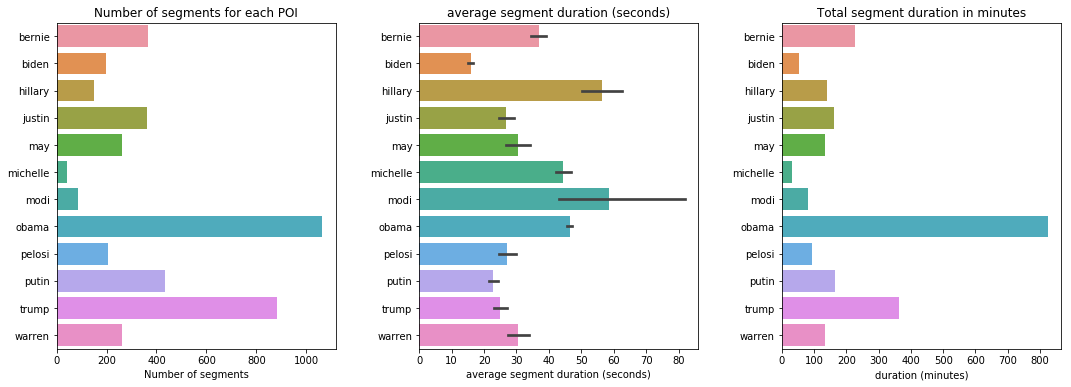

In [14]:
import seaborn as sns

#--------------------------------DEFINE USER IDENTITIES-----------------------------------
identities_modi =['bernie','biden','hillary','justin','may','michelle','modi','obama','pelosi','putin','trump','warren']
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(18,6))
#number of segments
total_videos = seg_df['video_id'].loc[seg_df['user_id'].isin(identities_modi)].groupby(seg_df['user_id']).count()
sns.barplot(y=total_videos.index, x= total_videos, orient='h', ax=ax[0])
ax[0].set_xlabel('Number of segments')
ax[0].set_title('Number of segments for each POI')
ax[0].set_ylabel('')

#average duration of each segment in seconds
seg_df = seg_df.loc[seg_df['user_id'].isin(identities_modi), :]
sns.barplot(y=seg_df['user_id'], x= seg_df['duration'], orient='h', ax=ax[1], order=identities_modi)
ax[1].set_xlabel('average segment duration (seconds)')
ax[1].set_title('average segment duration (seconds)')
ax[1].set_ylabel('')

#total minutes of video for each POI.
total_minutes = seg_df['duration'].loc[seg_df['user_id'].isin(identities_modi)].groupby(seg_df['user_id']).sum()/60
sns.barplot(y=total_minutes.index, x= total_minutes, orient='h', ax=ax[2])
ax[2].set_xlabel('duration (minutes)')
ax[2].set_title('Total segment duration in minutes')
ax[2].set_ylabel('')

plt.subplots_adjust(wspace=0.3)
plt.show()

Shown below are the duration split for train, validation and test dataset.

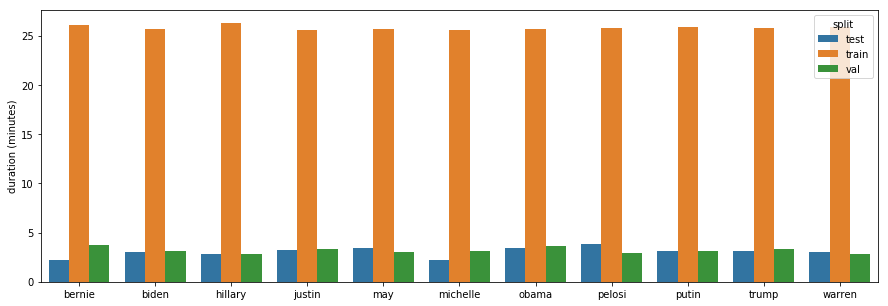

In [66]:
total_minutes = seg_df.groupby(['user_id', 'split'])['duration'].agg('sum').reset_index()
total_minutes['duration'] = total_minutes['duration']/60
plt.figure(figsize(15, 5))
sns.barplot(x='user_id', y= 'duration', orient='v', hue='split', data=total_minutes)
plt.ylabel('duration (minutes)')
plt.xlabel('')
plt.show()

### example

Shown below are the example frames from train, validation and test dataset for all the POIs. 

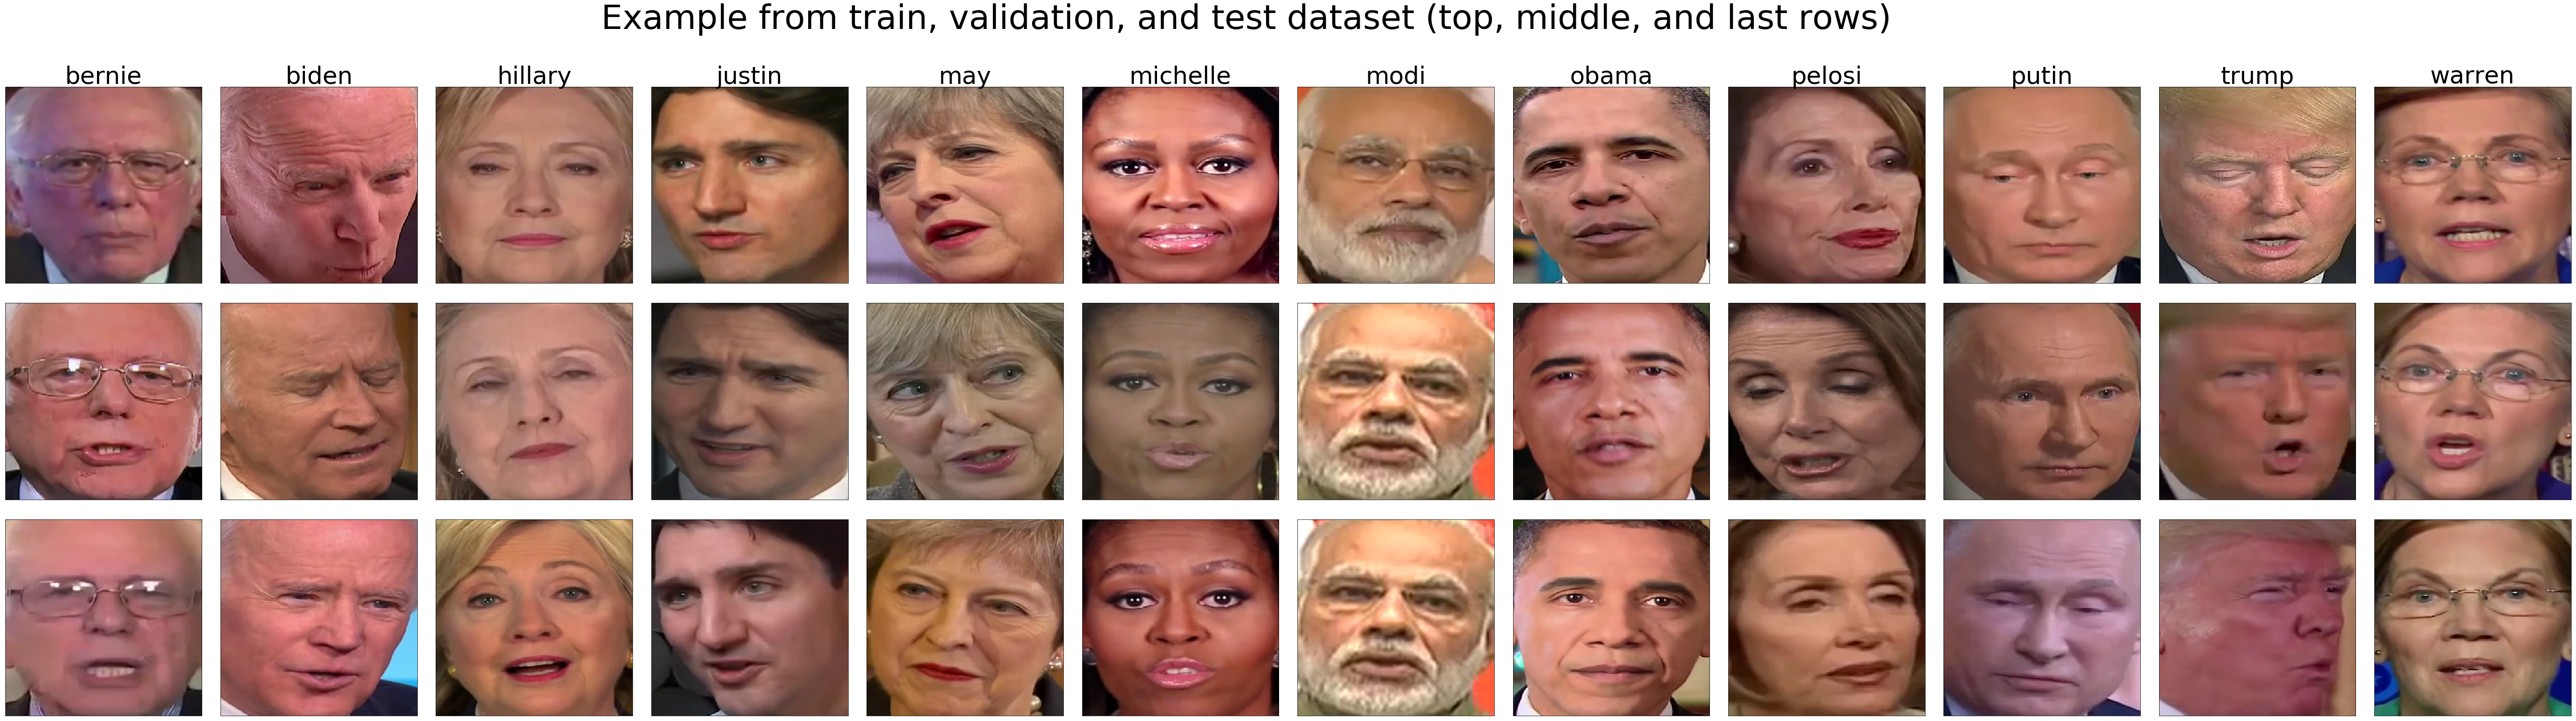

In [115]:
from data_utils import get_example_face
import re

splits = ['train', 'val', 'test']
fig, ax = plt.subplots(nrows=len(splits), ncols=len(identities), figsize=(96, 24))

for s in range(len(splits)):
    for i in range(len(identities)):
        cur_path = seg_df[np.logical_and(seg_df['user_id']==identities[i], 
                                         seg_df['split']==splits[s])]['file_path'].sample(n=1, random_state=31).iloc[0]
        face = get_example_face(re.sub('.csv', '.mp4', cur_path))
        ax[s, i].imshow(np.squeeze(face[0, :, :, :]).astype('uint8'))
        if s == 0:
            ax[s, i].set_title(identities[i], fontsize=50)
        ax[s, i].set_xticks([])
        ax[s, i].set_yticks([])
        
plt.subplots_adjust(hspace=0.1, wspace=0)
plt.suptitle('Example from train, validation, and test dataset (top, middle, and last rows)', fontsize=70)
plt.show()

### fake videos

For fake videos, we used two types of datasets. As we exploit the facial expressions of the person when they talk, we used videos where the POI speaking style was impersonated by someone else. In addition to this, we created faceswap videos for the POIs.

Below we show the duration of videos we have for each POI and example frames. Notice there were no faceswap or imposter videos collected for many POIs. But we believe we have enough videos to validate our technique.

In [15]:
all_segments = 'fakes'
from data_utils import get_vid_stats_fake

out_seg_stats = 'fake_stat.csv'

if not os.path.exists(out_seg_stats):
    seg_df = get_vid_stats_fake(all_segments)
    seg_df.to_csv(out_seg_stats)

seg_df = pd.read_csv(out_seg_stats)

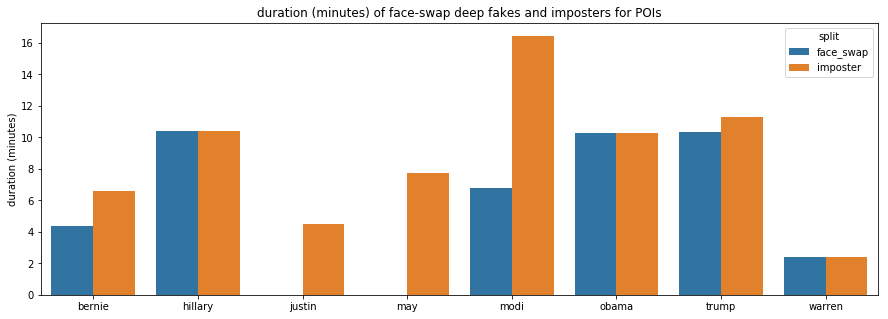

    user_id      split   duration
0    bernie  face_swap   4.348333
1    bernie   imposter   6.623333
2   hillary  face_swap  10.416667
3   hillary   imposter  10.401111
4    justin   imposter   4.497222
5       may   imposter   7.728889
6      modi  face_swap   6.798333
7      modi   imposter  16.443889
8     obama  face_swap  10.259444
9     obama   imposter  10.248333
10    trump  face_swap  10.333333
11    trump   imposter  11.283889
12   warren  face_swap   2.415556
13   warren   imposter   2.405556


In [16]:
total_minutes = seg_df.groupby(['user_id', 'split'])['duration'].agg('sum').reset_index()
total_minutes['duration'] = total_minutes['duration']/60
plt.figure(figsize(15, 5))
sns.barplot(x='user_id', y= 'duration', orient='v', hue='split', data=total_minutes)
plt.ylabel('duration (minutes)')
plt.xlabel('')
plt.title('duration (minutes) of face-swap deep fakes and imposters for POIs')
plt.show()

print(total_minutes)

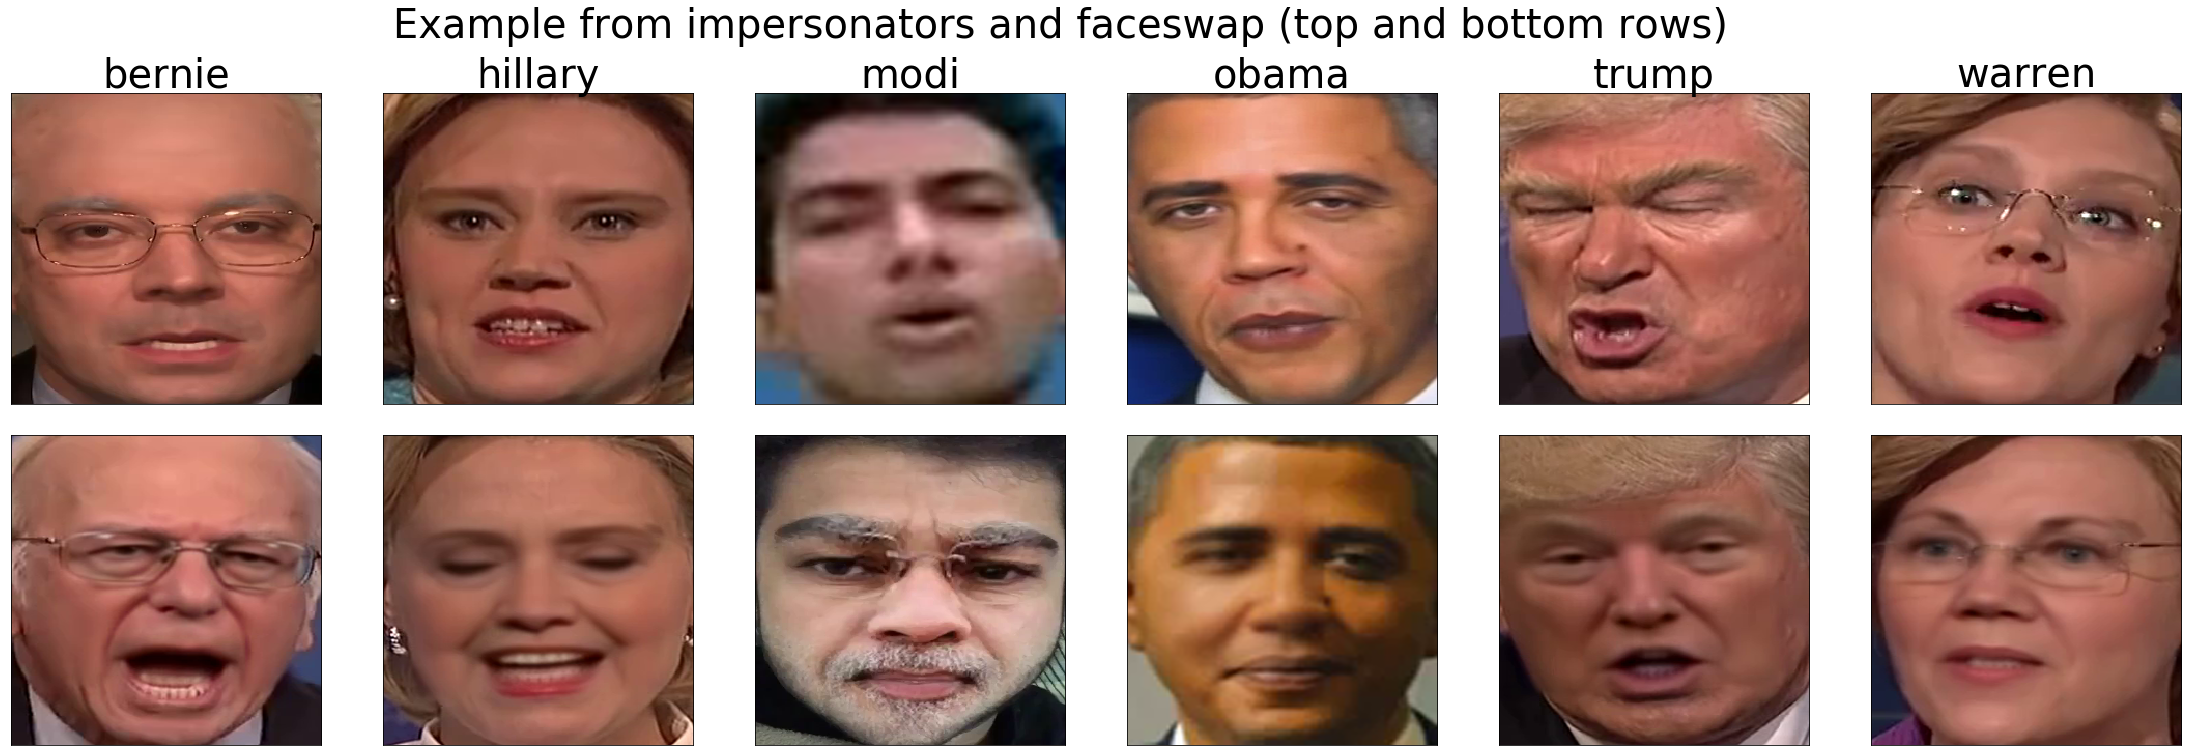

In [137]:
from data_utils import get_example_face
import re

splits = ['imposter', 'face_swap']

pois = []

for i in range(len(identities)):
    cur_path_fs = seg_df[np.logical_and(seg_df['user_id']==identities[i], 
                                     seg_df['split']==splits[0])]['file_path']

    cur_path_i = seg_df[np.logical_and(seg_df['user_id']==identities[i], 
                                     seg_df['split']==splits[1])]['file_path']    

    if len(cur_path_fs)>0 and len(cur_path_i)>0:
        pois.extend([identities[i]])

fig, ax = plt.subplots(nrows=len(splits), ncols=len(pois), figsize=(40, 12))
for s in range(len(splits)):
    for i in range(len(pois)):
        cur_path = seg_df[np.logical_and(seg_df['user_id']==pois[i], 
                                         seg_df['split']==splits[s])]['file_path'].sample(n=1, random_state=0).iloc[0]
        face = get_example_face(re.sub('.csv', '.mp4', cur_path))
        ax[s, i].imshow(np.squeeze(face[0, :, :, :]).astype('uint8'))
        if s == 0:
            ax[s, i].set_title(pois[i], fontsize=40)
        ax[s, i].set_xticks([])
        ax[s, i].set_yticks([])
        
plt.subplots_adjust(hspace=0.1, wspace=0)
plt.suptitle('Example from impersonators and faceswap (top and bottom rows)', fontsize=40)
plt.show()

## 3) Landmark extraction

We use OpenFace2.0 open source library to extract the facial landmark, facial action units and head motion of each speaker. Using the OpenFace library, we tracked the following facial features:

<ul>
  <li> 3 features: by the 3D rotation of the head about the x-axis, y-axis, and z-axis </li>
  <li> 136 feature: 68 3D facial landmarks. Each landmark was rotated to remove above 3D rotation and points were scaled to have a unit distance between the two eyes. We discard the z cordinate and used only x and y cordinates. </li>
  <li> 17 Action Units: The OpenFace2 toolkit provides the intensity and occurrence for $17$ AUs: inner brow raiser (AU01), outer brow raiser (AU02), brow lowerer (AU04), upper lid raiser (AU05), cheek raiser (AU06), lid tightener (AU07), nose wrinkler (AU09), upper lip raiser (AU10), lip corner puller (AU12), dimpler (AU14), lip corner depressor (AU15), chin raiser (AU17), lip stretcher (AU20), lip tightener (AU23), lip part (AU25), jaw drop (AU26), eye blink (AU45)</li>
</ul>

Shown below is an example annotated of the annotated landmark positions, head rotation, and the intensity of the inner brow raiser AU01.

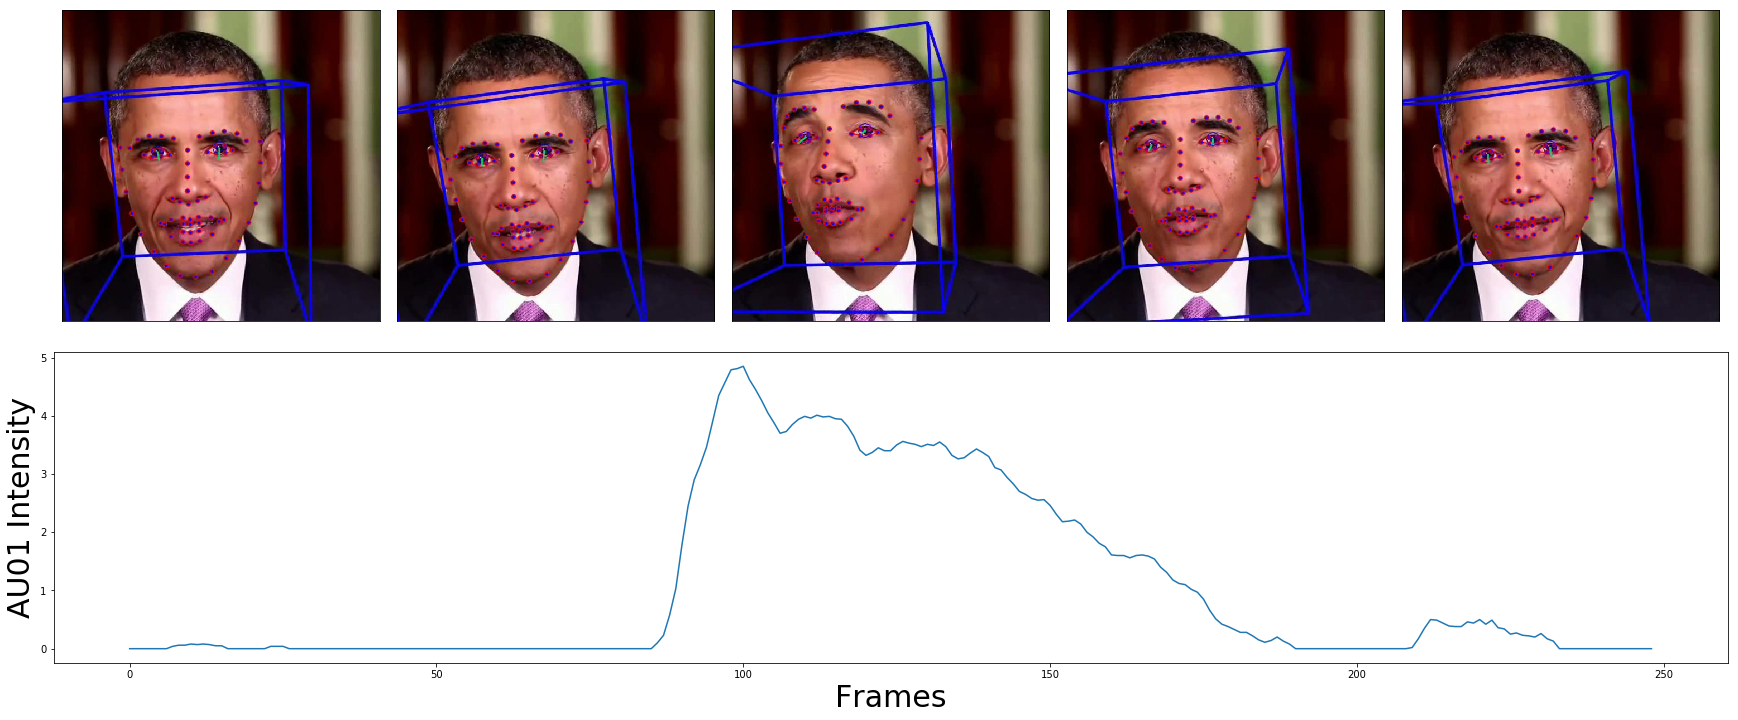

In [160]:
import cv2 

fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(30, 12))
grid = plt.GridSpec(2, 5, wspace=0, hspace=0.1)
ims = ['openface/frame0.jpg', 'openface/frame50.jpg', 
       'openface/frame100.jpg', 'openface/frame150.jpg', 
       'openface/frame200.jpg']
for i in range(5):
    ax = plt.subplot(grid[0, i])
    im = cv2.cvtColor(cv2.imread(ims[i]), cv2.COLOR_BGR2RGB)
    ax.imshow(im)
    ax.set_xticks([])
    ax.set_yticks([])
    
    
aus = np.array(pd.read_csv('openface/-my9hVoGv2M_4.csv')[' AU01_r'])
idx = np.argmax(aus)
fr_nm = np.arange(idx-100, idx+149)
ax = plt.subplot(grid[1, :])
ax.plot(aus[fr_nm])
ax.set_xlabel('Frames', fontsize=30)
ax.set_ylabel('AU01 Intensity', fontsize=30)
plt.show()